In [1]:
import numpy as np
import pandas as pd

import squarify
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')

In [53]:
holidays = pd.read_csv('data/holidays_events.csv')
oil = pd.read_csv('data/oil.csv')
stores = pd.read_csv('data/stores.csv')
transactions = pd.read_csv('data/transactions.csv')

train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)

In [54]:
# Функция для перевода даты в численный вид
def convert_date_to_number(df, date_column='date'):
    df[date_column] = pd.to_datetime(df['date'])
    df['date'] = (df['date'] - pd.Timestamp('2012-01-01')).dt.days
    
    return df

## EDA + FE

Проанализируем сначала данные `holidays`

In [55]:
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [56]:
holidays.describe(include='O')

,date,type,locale,locale_name,description
count,350,350,350,350,350
unique,312,6,3,24,103
top,2014-06-25,Holiday,National,Ecuador,Carnaval
freq,4,221,174,174,10


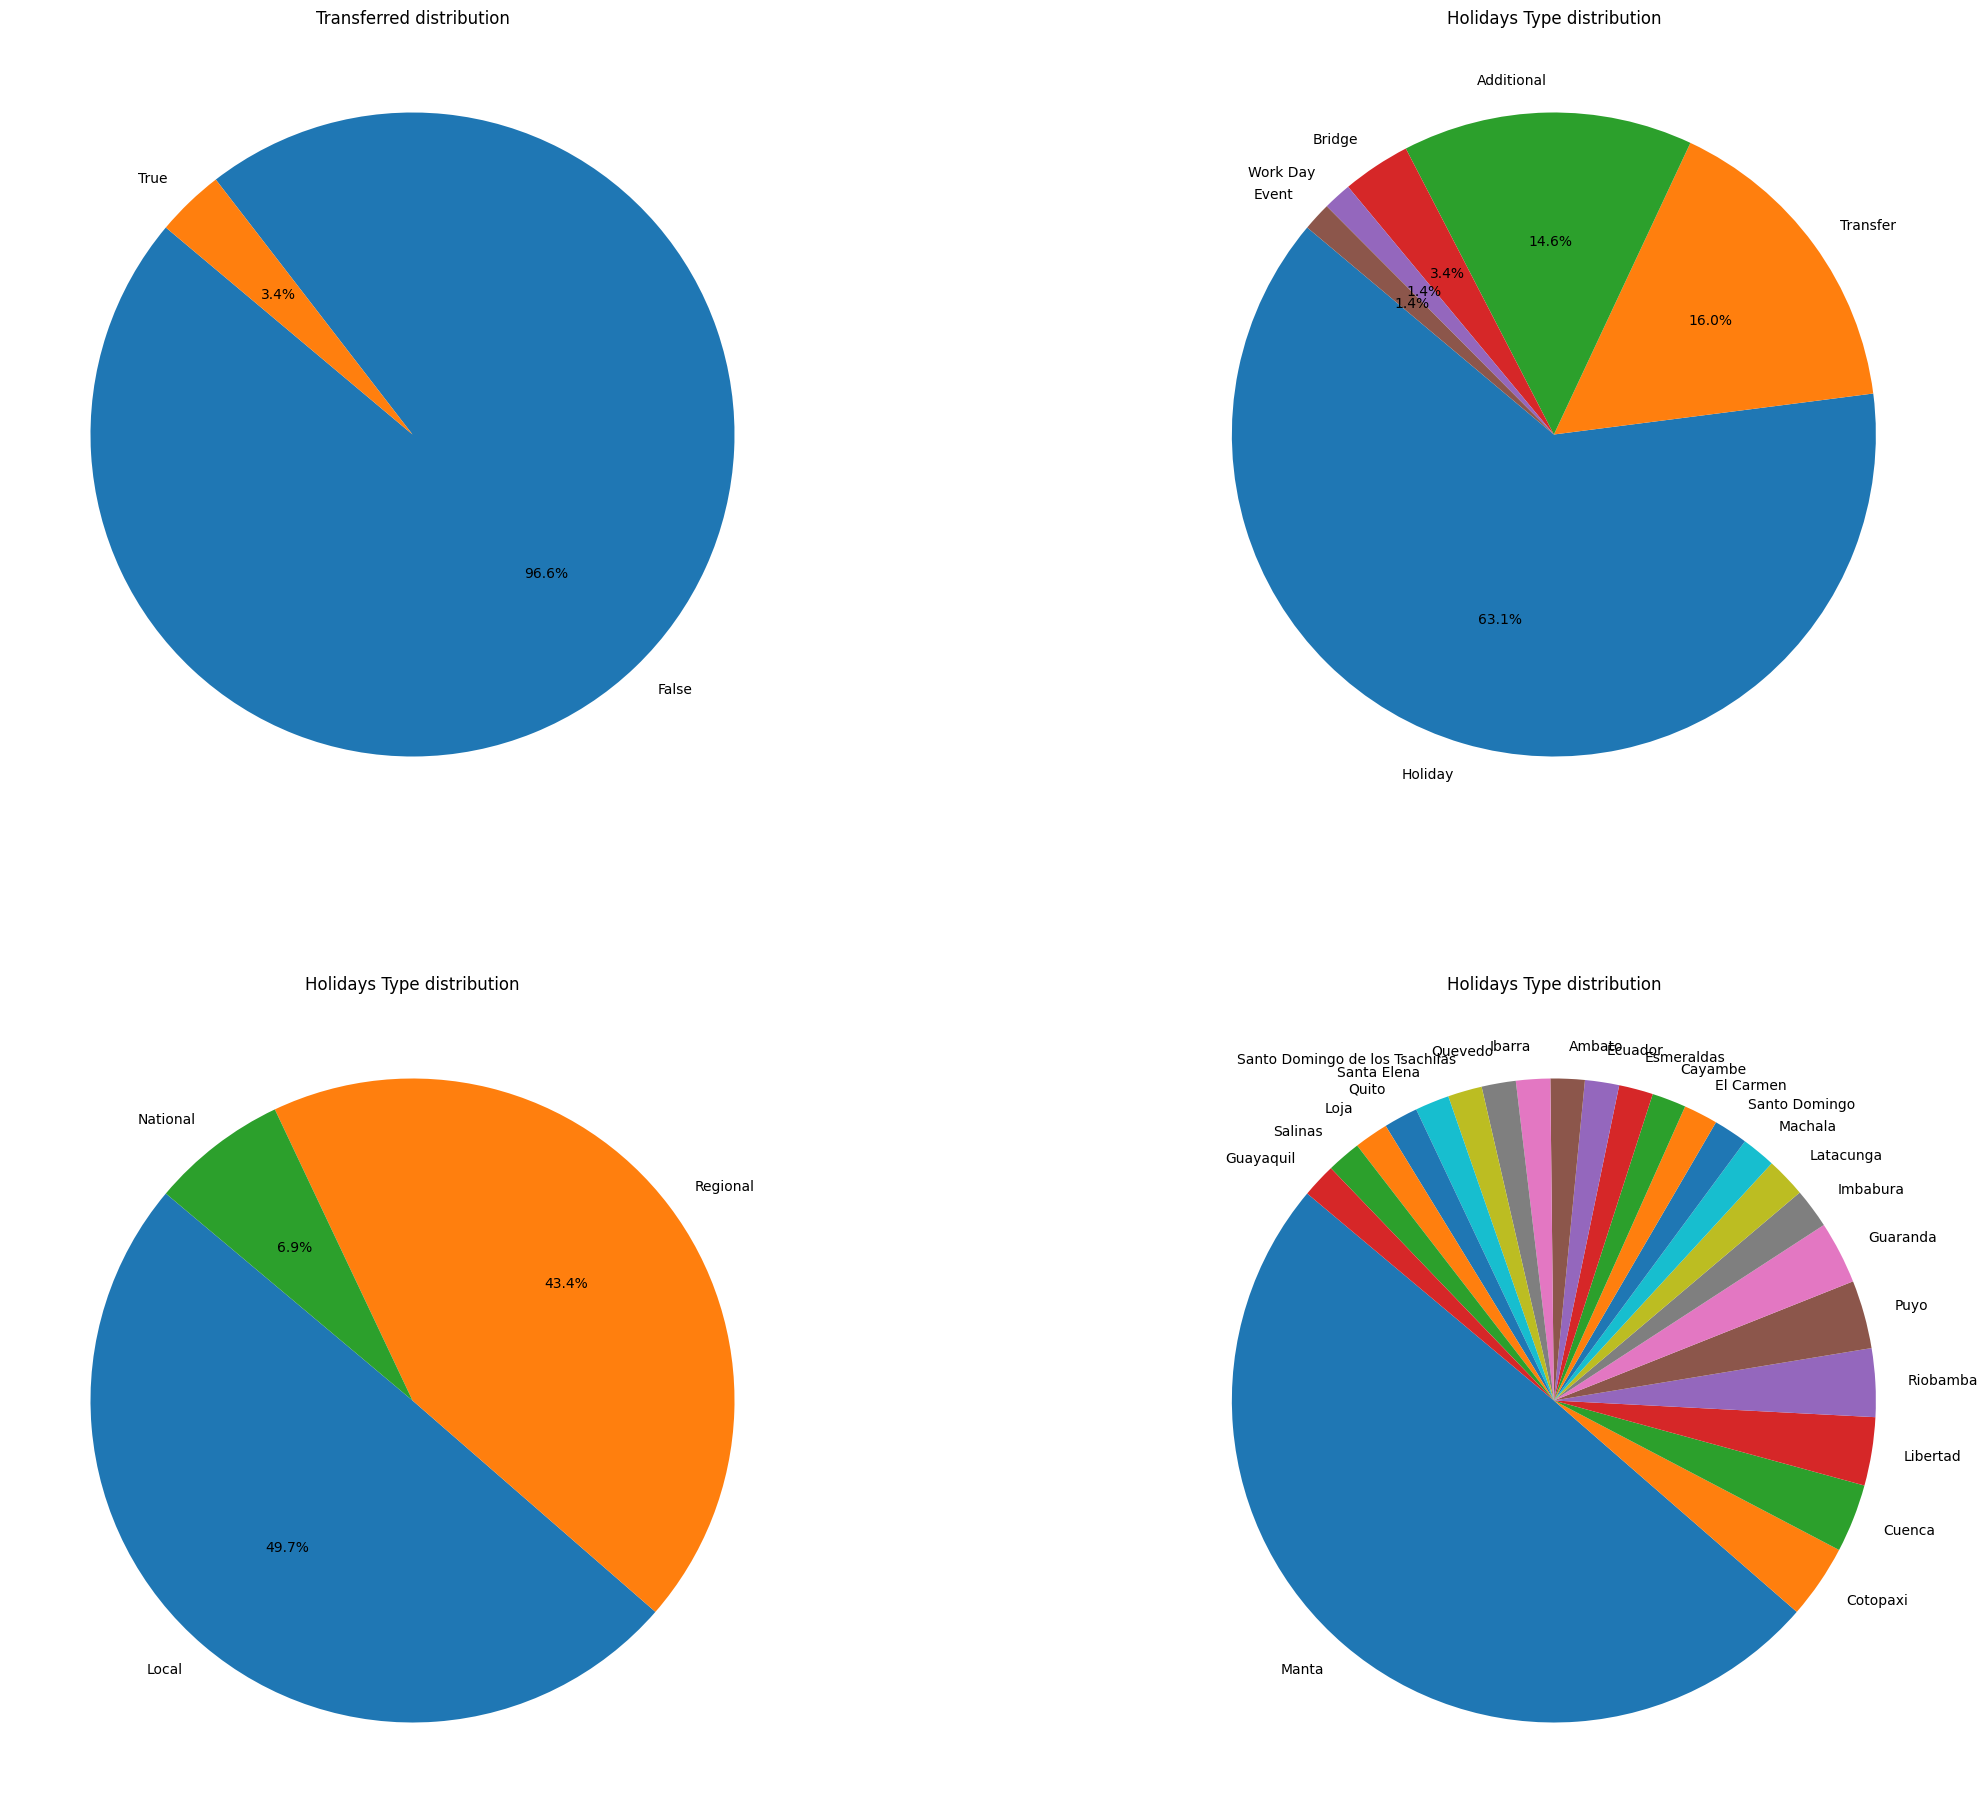

In [57]:
plt.figure(figsize=(27, 23))

# Посмотрим на доли классов
plt.subplot(2, 2, 1)
plt.title('Transferred distribution', fontsize=12)
plt.pie(holidays.transferred.value_counts(), labels=holidays.transferred.unique(), 
        autopct='%1.1f%%', startangle=140)

plt.subplot(2, 2, 2)
plt.title('Holidays Type distribution', fontsize=12)
plt.pie(holidays.type.value_counts(), labels=holidays.type.unique(), 
        autopct='%1.1f%%', startangle=140)

plt.subplot(2, 2, 3)
plt.title('Holidays Type distribution', fontsize=12)
plt.pie(holidays.locale.value_counts(), labels=holidays.locale.unique(), 
        autopct='%1.1f%%', startangle=140)\
    
plt.subplot(2, 2, 4)
plt.title('Holidays Type distribution', fontsize=12)
plt.pie(holidays.locale_name.value_counts(), labels=holidays.locale_name.unique(), startangle=140);

In [58]:
# Сравним продажи в период перенесенных и неперенесенных праздничных дней
transferred_holidays_dates = holidays[holidays.transferred].date
holidays_dates = holidays[~holidays.transferred].date

transferred_holidays_sales = train[train.date.isin(transferred_holidays_dates)].sales
holidays_sales = train[train.date.isin(holidays_dates)].sales
workdays_sales = train[(~train.date.isin(holidays_dates) & 
                        ~train.date.isin(transferred_holidays_dates))].sales

pd.concat([
    workdays_sales.describe(),
    transferred_holidays_sales.describe(),
    holidays_sales.describe()
], axis=1).astype(int)

,sales,sales,sales
count,2551824,16038,433026
mean,352,311,392
std,1076,935,1248
min,0,0,0
25%,0,0,0
50%,11,10,12
75%,193,160,214
max,40351,20106,124717


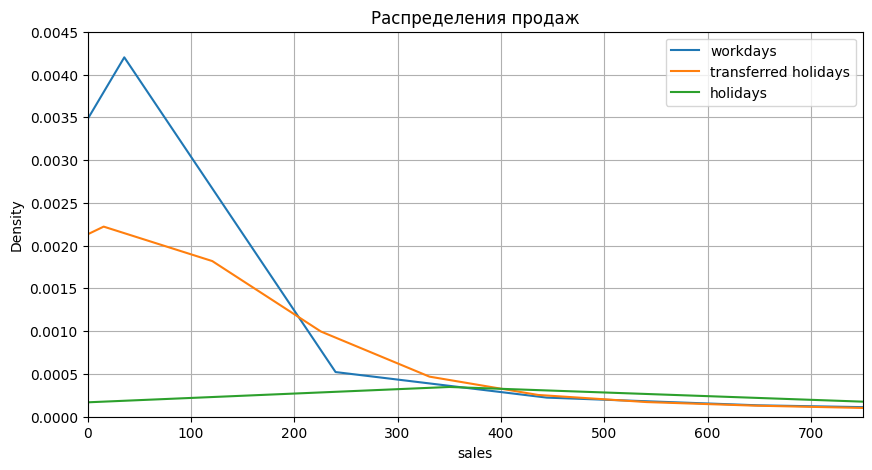

In [59]:
plt.figure(figsize=(10, 5))

plt.title('Распределения продаж')
sns.kdeplot(workdays_sales, label='workdays')
sns.kdeplot(transferred_holidays_sales, label='transferred holidays')
sns.kdeplot(holidays_sales, label='holidays')

plt.axis((0, 750, 0, 0.0045))
plt.legend()
plt.grid();

In [60]:
# Поставим каждому празднику среднее от кол-ва продаж
date_and_sales = train[train.date.isin(holidays.date)][['date', 'sales']]
desc_mean_sales = holidays.merge(date_and_sales, on='date').groupby('description', as_index=False).sales.mean()
holidays = holidays.merge(desc_mean_sales, on='description')

# Вычтем из sales среднее от продаж в рабочие дни
holidays.sales -= 352

In [61]:
holidays

,date,type,locale,locale_name,description,transferred,sales
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,38.121840
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,75.235778
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,-7.377588
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,-65.681083
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,-3.257866
...,...,...,...,...,...,...,...
338,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False,206.662990
339,2017-12-22,Additional,National,Ecuador,Navidad-3,False,206.662990
340,2017-12-23,Additional,National,Ecuador,Navidad-2,False,256.324191
341,2017-12-24,Additional,National,Ecuador,Navidad-1,False,197.546061


In [62]:
desc_mean_sales

,description,sales
0,Batalla de Pichincha,337.347448
1,Black Friday,363.360708
2,Cantonizacion de Cayambe,367.959454
3,Cantonizacion de El Carmen,424.582172
4,Cantonizacion de Guaranda,323.335566
...,...,...
96,Traslado Fundacion de Guayaquil,475.795554
97,Traslado Independencia de Guayaquil,310.152684
98,Traslado Primer Grito de Independencia,441.087606
99,Traslado Primer dia del ano,786.928379


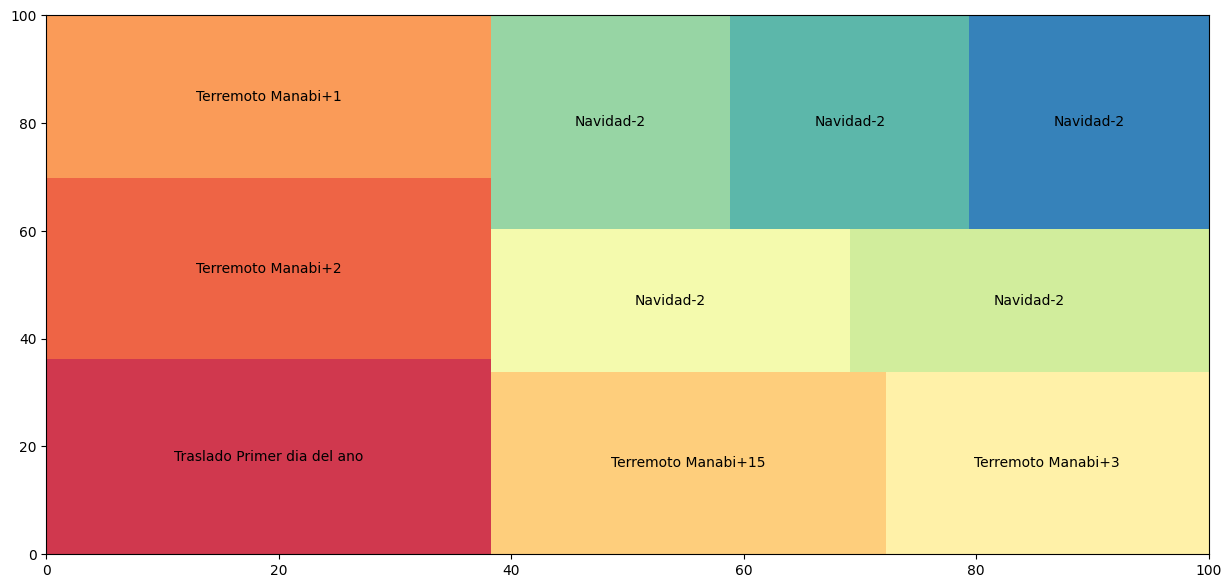

In [63]:
plt.figure(figsize=(15, 7))

# Топ 10 самых прибыльных праздников
top_10_desc = holidays[['description', 'sales']].sort_values(by='sales', ascending=False).head(10)
squarify.plot(top_10_desc.sales, label=top_10_desc.description,
              color=sns.color_palette('Spectral', len(top_10_desc)));

In [64]:
from category_encoders.cat_boost import CatBoostEncoder

# Переведем date в численный вид
holidays = convert_date_to_number(holidays) 

# Используем CatBoostEncoder для категориальных признаков(sales удалим)
holidays_cb_enc = CatBoostEncoder(cols=['type', 'locale', 'locale_name', 'description'])
holidays = holidays_cb_enc.fit_transform(holidays.drop('sales', axis=1), holidays.sales)

# Переведем transferred в численный вид
holidays.transferred = holidays.transferred.astype(int)

# Сгруппируем даты и усредним вектора праздников
holidays = holidays.groupby('date', as_index=False).mean()

In [65]:
holidays

,date,type,locale,locale_name,description,transferred
0,61,44.971838,44.971838,44.971838,44.971838,0.0
1,91,41.546839,44.971838,44.971838,44.971838,0.0
2,102,52.776485,41.546839,44.971838,44.971838,0.0
3,104,37.737967,25.238696,44.971838,44.971838,0.0
4,111,17.054157,2.508751,44.971838,44.971838,0.0
...,...,...,...,...,...,...
301,2181,135.561337,68.541987,68.541987,181.388998,0.0
302,2182,73.973090,42.150653,124.552863,179.714465,0.0
303,2183,138.504454,70.218200,70.218200,221.098798,0.0
304,2184,140.860849,71.332608,71.332608,172.117024,0.0


Теперь таблицу `oil`

In [66]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [67]:
oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [68]:
# Переведем date в численный вид
oil = convert_date_to_number(oil)

# Увеличим данные(заполним пропущенные дни)
oil_dates = pd.DataFrame({'date': range(oil.date.min(), oil.date.max() + 1)})
oil = oil_dates.merge(oil, on='date', how='left')

In [69]:
# Заполним пропуски средним значением соседей
nan_oil_ids = np.where(oil.isna())[0]

for idx in nan_oil_ids:
    l_idx = idx - 1 if pd.notna(oil.iloc[idx - 1, 1]) and idx > 0 else idx + 1
    r_idx = idx + 1 if pd.notna(oil.iloc[idx + 1, 1]) and idx < oil.shape[0] - 1 else idx - 1
    
    oil.iloc[idx, 1] = (oil.iloc[l_idx, 1] + oil.iloc[r_idx, 1]) / 2

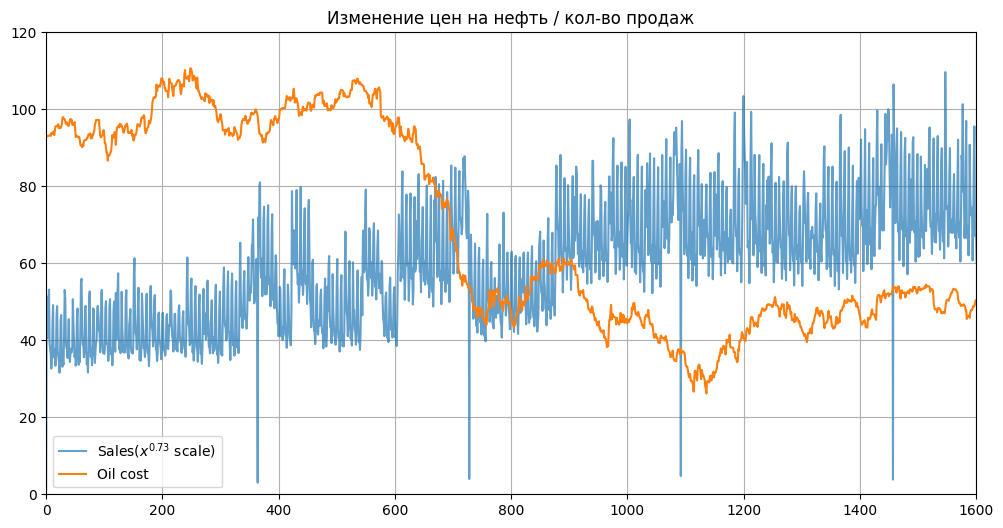

In [70]:
# Отобразим зависимость продаж от цен на нефть
plt.figure(figsize=(12, 6))
plt.title('Изменение цен на нефть / кол-во продаж')

plt.plot(train.groupby('date').sales.mean().to_numpy() ** 0.7, alpha=0.7, label='Sales($x^{0.73}$ scale)')
plt.plot(oil.iloc[:, 1], label='Oil cost')

plt.grid()
plt.axis((0, 1600, 0, 120))
plt.legend();

Рассмотрим `stores`

In [71]:
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [72]:
# Переведем тип магазина так, чтобы A=1, ..., E=5
stores.type = stores.type.apply(ord) - 64

In [73]:
stores.describe(include='all')

,store_nbr,city,state,type,cluster
count,54.000000,54,54,54.000000,54.000000
unique,NaN,22,16,NaN,NaN
top,NaN,Quito,Pichincha,NaN,NaN
freq,NaN,18,19,NaN,NaN
mean,27.500000,NaN,NaN,3.000000,8.481481
std,15.732133,NaN,NaN,1.213136,4.693395
min,1.000000,NaN,NaN,1.000000,1.000000
25%,14.250000,NaN,NaN,2.000000,4.000000
50%,27.500000,NaN,NaN,3.000000,8.500000
75%,40.750000,NaN,NaN,4.000000,13.000000


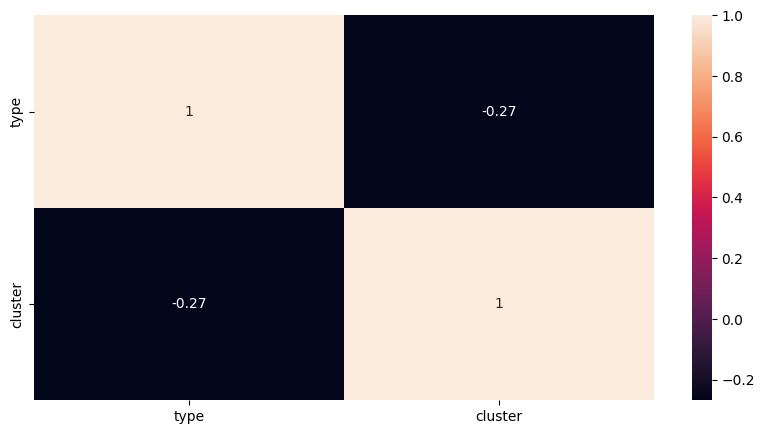

In [74]:
# Посмотрим на зависимость между типом магазина и кластером
plt.figure(figsize=(10, 5))
sns.heatmap(stores[['type', 'cluster']].corr(), annot=True);

In [75]:
stores_mean_sales = train.groupby('store_nbr', as_index=False).sales.mean()
stores = stores.merge(stores_mean_sales, on='store_nbr')

stores

,store_nbr,city,state,type,cluster,sales
0,1,Quito,Pichincha,4,13,254.534889
1,2,Quito,Pichincha,4,13,387.918172
2,3,Quito,Pichincha,4,8,908.405495
3,4,Quito,Pichincha,4,9,340.273886
4,5,Santo Domingo,Santo Domingo de los Tsachilas,4,4,280.580231
5,6,Quito,Pichincha,4,13,453.172101
6,7,Quito,Pichincha,4,8,484.993334
7,8,Quito,Pichincha,4,8,548.734739
8,9,Quito,Pichincha,2,6,475.229271
9,10,Quito,Pichincha,3,15,172.999096


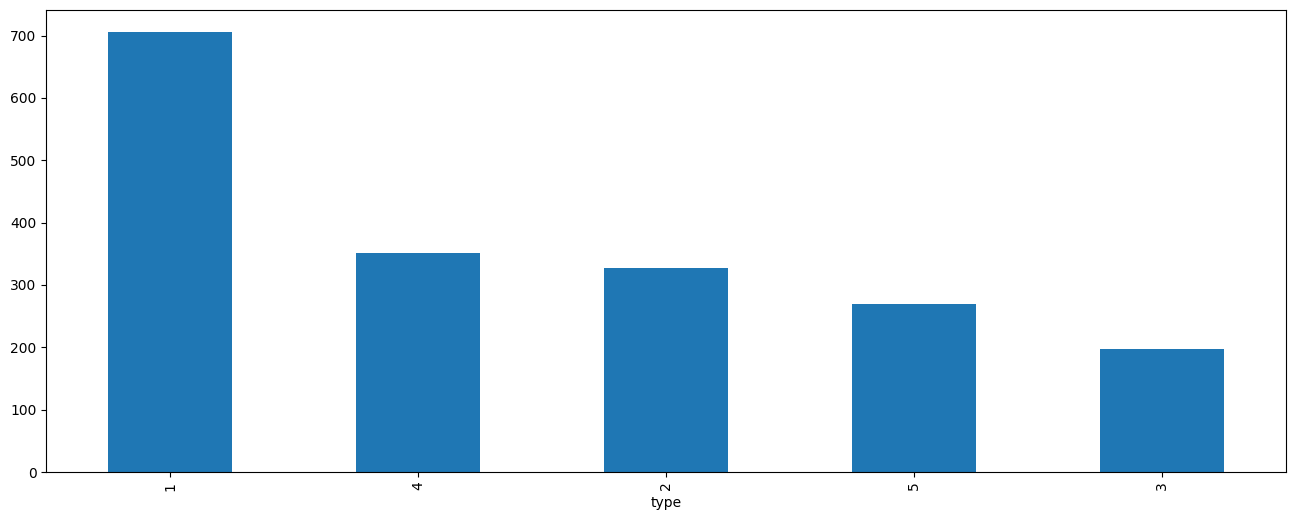

In [76]:
# Посмотрим на продажи каждого класса магазинов
plt.figure(figsize=(16, 6))
stores.groupby('type').sales.mean().sort_values(ascending=False).plot(kind='bar');

In [77]:
# Вычтем из sales среднее от продаж в рабочие дни
stores.sales -= 352 

# Используем CatBoostEncoder для категориальных признаков(sales удалим)
stores_cb_enc = CatBoostEncoder(cols=['city', 'state', 'type'])
stores = stores_cb_enc.fit_transform(stores.drop('sales', axis=1), stores.sales)

Наконец посмотрим на `train` и объединим все данные в один фрейм

In [208]:
train

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


In [209]:
train.describe(include='all')

,date,store_nbr,family,sales,onpromotion
count,3000888,3.000888e+06,3000888,3.000888e+06,3.000888e+06
unique,1684,NaN,33,NaN,NaN
top,2017-08-15,NaN,AUTOMOTIVE,NaN,NaN
freq,1782,NaN,90936,NaN,NaN
mean,NaN,2.750000e+01,NaN,3.577757e+02,2.602770e+00
std,NaN,1.558579e+01,NaN,1.101998e+03,1.221888e+01
min,NaN,1.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,NaN,1.400000e+01,NaN,0.000000e+00,0.000000e+00
50%,NaN,2.750000e+01,NaN,1.100000e+01,0.000000e+00
75%,NaN,4.100000e+01,NaN,1.958473e+02,0.000000e+00


C:\Users\79773\AppData\Local\Temp\ipykernel_61864\3969921094.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=families_sales.sort_values('sales', ascending=True), x='family', y='sales',


<Axes: title={'center': 'Family Vs Sales'}, xlabel='family', ylabel='sales'>

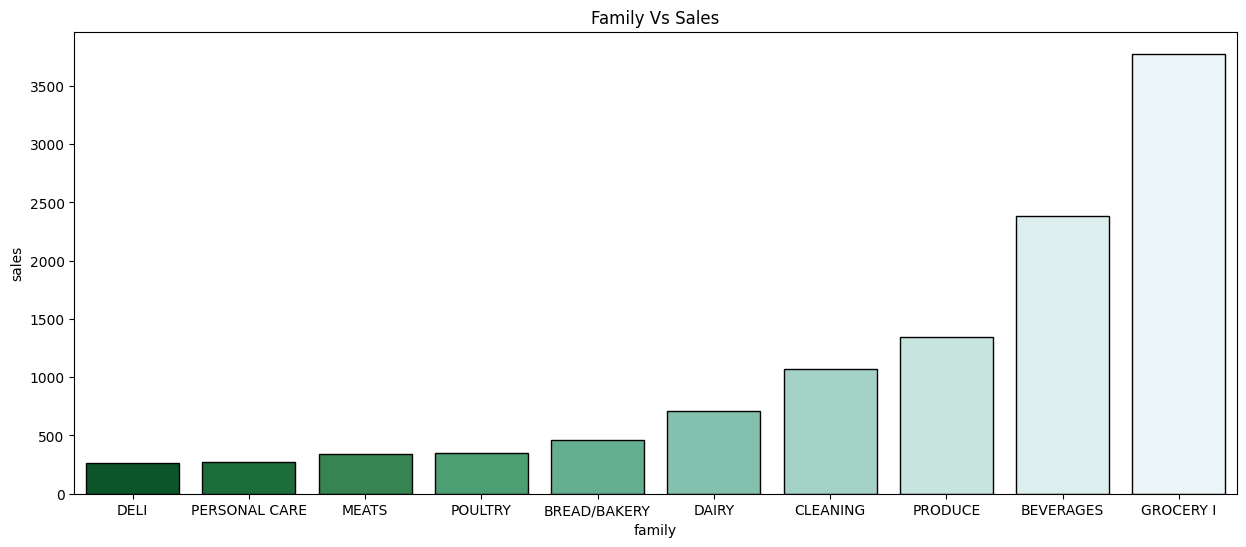

In [210]:
#  Распределение 
plt.figure(figsize=(15, 6))

plt.title('Family Vs Sales')
families_sales = train.groupby('family', as_index=False).sales.mean()
families_sales = families_sales.sort_values('sales', ascending=False).head(10)

sns.barplot(data=families_sales.sort_values('sales', ascending=True), x='family', y='sales',
            palette=sns.color_palette("BuGn_r", n_colors=10), ec='k')

In [ ]:
train

In [217]:
def merging_data(data, encoder=None):
    global holidays, oil, stores
    data = data.copy()
    
    # Добавим новые столбцы
    data['month'] = pd.to_datetime(data['date']).dt.month
    data['is_weekend'] = pd.to_datetime(data['date']).dt.weekday.isin([5, 6]).astype(int)
    
    # Переведем date в численный вид
    data = convert_date_to_number(data)
    
    # Закодируем столбец family
    if encoder is None:
        encoder = CatBoostEncoder(cols=['family'])
        X, y = data.drop('sales', axis=1), data['sales']
        X = encoder.fit_transform(X, y - 352)  # Для кодировки вычтем из y среднее кол-во продаж в рабочие дни

    else:  # Если энкодер присутствует, то наличие target не нужно
        X = encoder.transform(data)
        y = None
    
    # Объединим все данные и заполним пропуски
    X = X.merge(holidays, on='date', how='left').fillna(0)  
    X = X.merge(oil, on='date', how='left')
    X = X.merge(stores, on='store_nbr', how='left')
        
    if y is not None:
        data = pd.concat([X, y], axis=1)
        
        return data, encoder
    else:
        return X

In [218]:
prep_train, enc = merging_data(train)
prep_test = merging_data(test, enc)

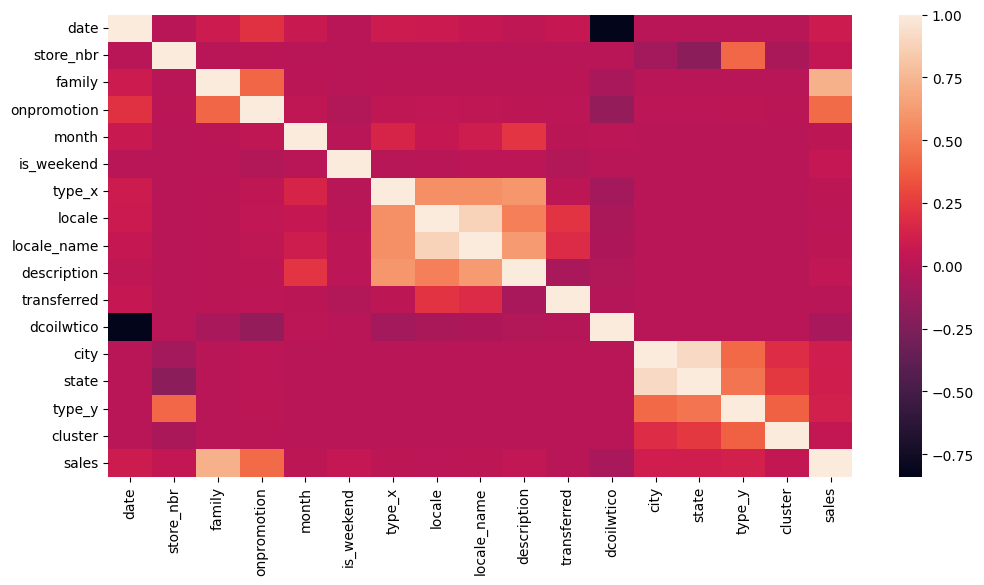

In [228]:
# Корреляционная матрица
corr_matrix = prep_train.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix);

In [220]:
# Сохраним данные
prep_train.to_csv('../data/preprocessing_train.csv', index=False)
prep_test.to_csv('../data/preprocessing_test.csv', index=False)